In [122]:
import pandas as pd
import joblib

test_df = pd.read_csv("../../data/test/test_full_features_qld.csv")

model = joblib.load("../../models/lightgbm_model.pkl")

test_df.head()

,latitude,longitude,gravity_iso_residual,gravity_cscba,gravity_cscba_1vd,mag_uc_1_2km,mag_uc_2_4km,mag_uc_4_8km,mag_uc_12_16km,radio_th_ppm,radio_u_ppm,radio_k_pct,radio_th_k_ratio,radio_u_k_ratio,radio_u_th_ratio
0,-21.616492,139.683149,313.274567,-1956.008545,43.961948,-47.661945,-77.192894,-110.089012,-61.585732,13.263866,1.630040,2.080019,6.378937,0.783630,0.123045
1,-12.146937,142.468403,337.870514,-867.062866,314.448486,-2.683037,-4.237718,-5.663266,-2.326362,8.827919,1.867436,0.134380,44.139595,9.337178,0.211963
2,-25.529801,144.816474,-221.057922,-705.243286,-477.396942,0.989375,1.833478,3.549671,2.982010,9.964523,1.150190,0.136905,49.822620,5.750950,0.115409
3,-28.467416,146.926187,-97.417801,-744.419800,-238.663727,-3.225788,-3.996645,-2.158727,-0.175468,8.817907,1.100841,0.833965,10.574533,1.321300,0.124960
4,-22.606888,149.245937,425.165405,141.858765,293.310577,1.897196,8.732470,20.499983,17.134827,12.920280,2.170410,1.045101,12.379150,2.079560,0.167982


In [123]:
import numpy as np
log1p_cols = [
    'radio_th_ppm', 'radio_u_ppm', 'radio_k_pct',
    'radio_th_k_ratio', 'radio_u_k_ratio', 'radio_u_th_ratio'
]

for col in log1p_cols:
    test_df[col] = pd.to_numeric(test_df[col], errors="coerce")
    test_df[f"{col}_log"] = np.log1p(test_df[col].clip(lower=0).fillna(0))


In [124]:
clip_mag_cols = [
    'mag_uc_1_2km', 'mag_uc_2_4km', 'mag_uc_4_8km', 'mag_uc_12_16km'
]

for col in clip_mag_cols:
    lower = test_df[col].quantile(0.01)
    upper = test_df[col].quantile(0.99)
    test_df[f"{col}_clipped"] = test_df[col].clip(lower, upper)


In [125]:
FEATURE_COLUMNS = [
    "gravity_iso_residual",
    "gravity_cscba",
    "gravity_cscba_1vd",
    "radio_th_ppm_log",
    "radio_u_ppm_log",
    "radio_k_pct_log",
    "radio_u_th_ratio_log",
    "radio_th_k_ratio_log",
    "radio_u_k_ratio_log",
    "mag_uc_1_2km_clipped",
    "mag_uc_2_4km_clipped",
    "mag_uc_4_8km_clipped",
    "mag_uc_12_16km_clipped"
]
test_df[FEATURE_COLUMNS] = test_df[FEATURE_COLUMNS].fillna(test_df[FEATURE_COLUMNS].median())

X = test_df[FEATURE_COLUMNS].copy()


In [126]:
test_df["prediction"] = model.predict_proba(X)[:, 1]
test_df.to_csv("../../data/test/test_full_features_qld_with_prediction.csv", index=False)



In [127]:
top_n = 20
top_df = test_df.sort_values(by="prediction", ascending=False).head(top_n).copy()
top_df

,latitude,longitude,gravity_iso_residual,gravity_cscba,gravity_cscba_1vd,mag_uc_1_2km,mag_uc_2_4km,mag_uc_4_8km,mag_uc_12_16km,radio_th_ppm,...,radio_u_ppm_log,radio_k_pct_log,radio_th_k_ratio_log,radio_u_k_ratio_log,radio_u_th_ratio_log,mag_uc_1_2km_clipped,mag_uc_2_4km_clipped,mag_uc_4_8km_clipped,mag_uc_12_16km_clipped,prediction
2837,-23.971634,147.257155,298.505737,-333.287750,-42.031303,5.168954,9.276085,12.139097,4.531595,NaN,...,0.0,0.0,0.0,0.0,0.0,5.168954,9.276085,12.139097,4.531595,0.992907
2557,-23.985439,147.194226,305.172638,-351.217285,-41.127251,-0.566684,0.214826,5.203134,7.869762,NaN,...,0.0,0.0,0.0,0.0,0.0,-0.566684,0.214826,5.203134,7.869762,0.992457
11637,-24.695827,147.560248,307.493347,-323.975067,-132.551041,-2.039198,-0.793116,4.147298,5.869149,NaN,...,0.0,0.0,0.0,0.0,0.0,-2.039198,-0.793116,4.147298,5.869149,0.992377
12151,-24.280103,147.196356,274.250366,-367.197021,-93.173126,3.536456,9.829369,21.707207,16.282282,NaN,...,0.0,0.0,0.0,0.0,0.0,3.536456,9.829369,21.707207,16.282282,0.992236
7669,-24.311930,147.782579,374.943970,-456.593018,29.564793,4.926404,3.317508,2.066506,1.676669,NaN,...,0.0,0.0,0.0,0.0,0.0,4.926404,3.317508,2.066506,1.676669,0.991034
16533,-24.126090,147.236398,297.260040,-367.871887,-55.916122,9.687481,16.200615,25.016975,14.717196,NaN,...,0.0,0.0,0.0,0.0,0.0,9.687481,16.200615,25.016975,14.717196,0.990872
11570,-23.851381,146.858148,261.875397,-201.030533,-86.451294,2.190803,3.563628,4.330796,2.728549,NaN,...,0.0,0.0,0.0,0.0,0.0,2.190803,3.563628,4.330796,2.728549,0.990814
6219,-23.895103,147.143093,303.849670,-441.242798,-44.490032,2.685390,10.569245,15.169849,5.917452,NaN,...,0.0,0.0,0.0,0.0,0.0,2.685390,10.569245,15.169849,5.917452,0.990575
27113,-23.756270,146.905649,276.323181,-195.174866,-67.035873,3.453190,6.807764,8.134396,1.341712,NaN,...,0.0,0.0,0.0,0.0,0.0,3.453190,6.807764,8.134396,1.341712,0.990404
935,-24.306463,147.411308,279.028687,-389.184143,-75.177658,14.884621,22.498436,30.140474,14.233974,NaN,...,0.0,0.0,0.0,0.0,0.0,14.884621,22.498436,30.140474,14.233974,0.990066


In [128]:
import geopandas as gpd
from shapely.geometry import Point


geometry_all = [Point(xy) for xy in zip(test_df["longitude"], test_df["latitude"])]
gdf_all = gpd.GeoDataFrame(test_df, geometry=geometry_all, crs="EPSG:4326")


geometry_top = [Point(xy) for xy in zip(top_df["longitude"], top_df["latitude"])]
gdf_top = gpd.GeoDataFrame(top_df, geometry=geometry_top, crs="EPSG:4326")


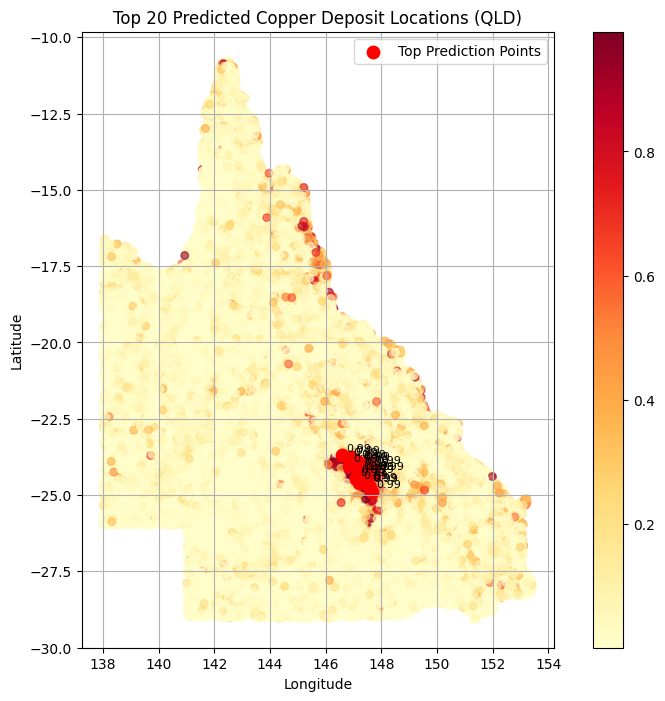

In [129]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))


gdf_all.plot(column="prediction", cmap="YlOrRd", legend=True, markersize=30, ax=ax, alpha=0.6)

gdf_top.plot(color="red", markersize=80, ax=ax, label="Top Prediction Points")


for idx, row in gdf_top.iterrows():
    ax.annotate(f"{row['prediction']:.2f}", xy=(row.geometry.x, row.geometry.y), xytext=(3, 3),
                textcoords="offset points", fontsize=8, color="black")

plt.title(f"Top {top_n} Predicted Copper Deposit Locations (QLD)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.legend()
plt.show()


In [120]:
df_real = pd.read_csv("../../data/processed/positive_core_clean.csv")
geometry_real = [Point(xy) for xy in zip(df_real["LONGITUDE"], df_real["LATITUDE"])]
gdf_real = gpd.GeoDataFrame(df_real, geometry=geometry_real, crs="EPSG:4326")

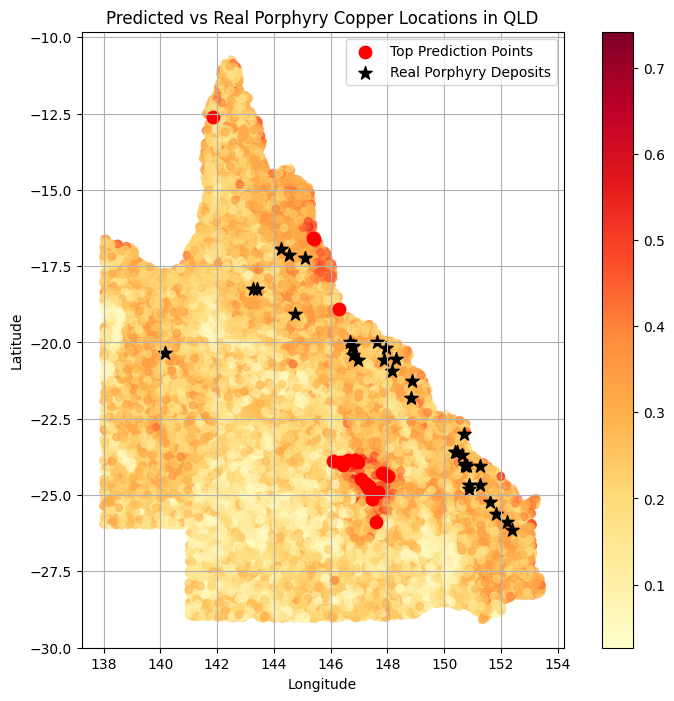

In [121]:

from shapely.geometry import box
qld_box = box(137.9, -29.0, 153.6, -10.5)
gdf_real_qld = gdf_real[gdf_real.intersects(qld_box)]

fig, ax = plt.subplots(figsize=(10, 8))

gdf_all.plot(column="prediction", cmap="YlOrRd", legend=True, ax=ax, markersize=30, alpha=0.6)
gdf_top.plot(color="red", markersize=80, ax=ax, label="Top Prediction Points")

gdf_real_qld.plot(ax=ax, color="black", marker="*", label="Real Porphyry Deposits", markersize=100)

plt.title("Predicted vs Real Porphyry Copper Locations in QLD")
plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

C:\Users\John\AppData\Local\Temp\ipykernel_32212\403517842.py:9: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buffered = gdf_top_web.unary_union.buffer(30000)


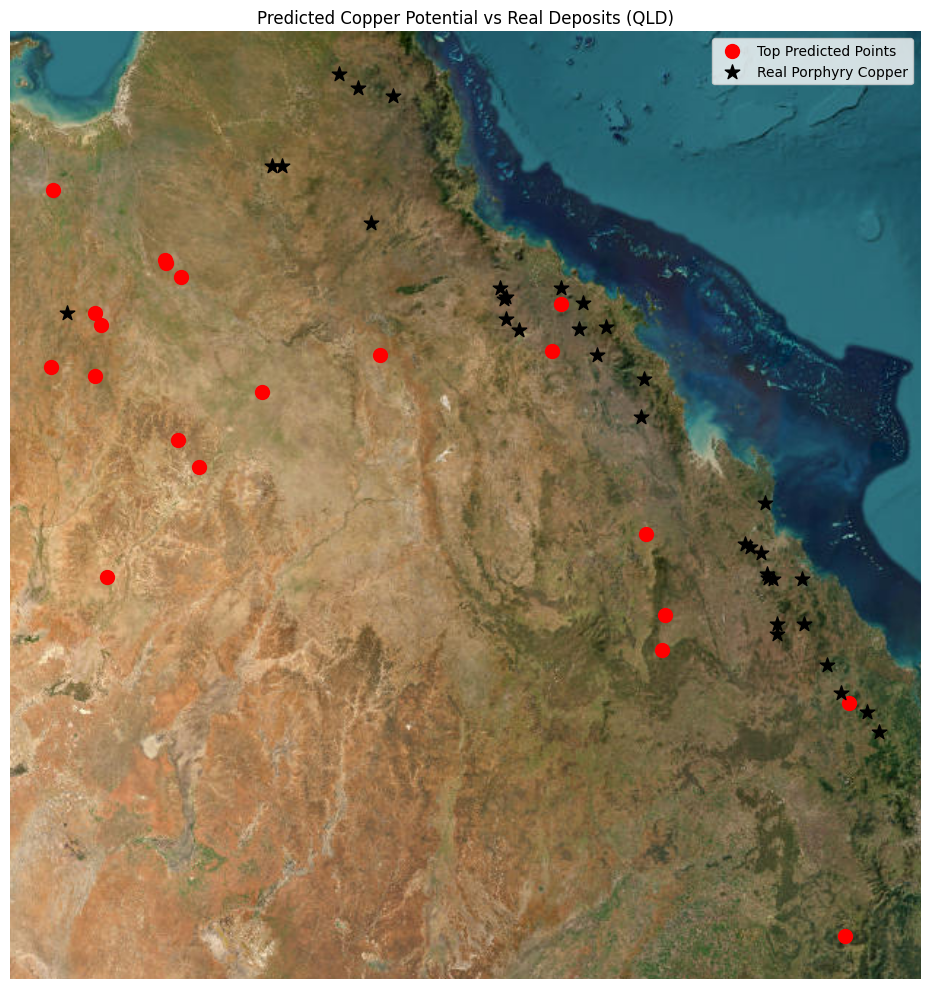

In [111]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point

gdf_top_web = gdf_top.to_crs(epsg=3857)
gdf_real_web = gdf_real_qld.to_crs(epsg=3857)

buffered = gdf_top_web.unary_union.buffer(30000)  
bbox = buffered.bounds 


fig, ax = plt.subplots(figsize=(12, 10))


'''
gdf_pred_web.plot(
    column="prediction",
    cmap="YlOrRd",
    legend=True,
    ax=ax,
    markersize=40,
    alpha=0.6
)
'''
gdf_top_web.plot(ax=ax, color="red", markersize=100, label="Top Predicted Points")


gdf_real_web.plot(
    ax=ax,
    color="black",
    marker="*",
    markersize=120,
    label="Real Porphyry Copper"
)


ctx.add_basemap(
    ax,
    source=ctx.providers.Esri.WorldImagery,  
    zoom=6,
    attribution=False
)


plt.title("Predicted Copper Potential vs Real Deposits (QLD)")
plt.legend()
plt.axis("off")
plt.tight_layout()
plt.show()


In [32]:
# 为真实矿点创建 buffer 区域
gdf_real_buffered = gdf_real_qld.to_crs(epsg=3857).buffer(50000)  # 10 km

# 检查高分点是否落入真实矿点缓冲区内
gdf_top_web["near_real"] = gdf_top_web.geometry.apply(
    lambda pt: any(pt.within(b) for b in gdf_real_buffered)
)

# 查看命中情况
print(gdf_top_web[["prediction", "near_real"]])


       prediction  near_real
25041    0.994479      False
26842    0.988600      False
2244     0.975012      False
3482     0.960523       True
12959    0.959390      False
10096    0.952565       True
15262    0.917679      False
13731    0.907807      False
12808    0.901486       True
17474    0.897305      False
13193    0.895592       True
18969    0.888065      False
24530    0.887486      False
22956    0.883007       True
12045    0.862358      False
8467     0.859853      False
22591    0.814475      False
3794     0.805778      False
16393    0.795976      False
16746    0.795976      False
2557     0.790261      False
7471     0.783783       True
6299     0.780200      False
8997     0.776892       True
22596    0.769178       True
26522    0.765203      False
4181     0.761460      False
13688    0.758737      False
4860     0.758354      False
15176    0.756229       True
10018    0.755328      False
21346    0.748044      False
29745    0.747308      False
26414    0.743